# Housing Price Prediction: A Comprehensive Machine Learning Approach

In today’s data-driven world, predicting housing prices accurately has become a key factor for real estate markets, financial institutions, and individual buyers alike. With numerous factors influencing property values—ranging from physical attributes like area and bedrooms to external factors like location and amenities—developing a robust prediction model is crucial.

This project aims to tackle the challenge of housing price prediction using advanced machine learning techniques. By leveraging a dataset with various features (including categorical and numerical variables), we will explore several key tasks such as outlier detection, feature engineering, and model training.

___

##### Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Importing the ML libraries
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn import ensemble, metrics, tree

import os
from pathlib import Path

Matplotlib is building the font cache; this may take a moment.


In [2]:
print("numpy version: ", np.__version__, 
      "\npandas version: ", pd.__version__,
      "\nseaborn version: ", sns.__version__, 
      "\nmatplotlib version: ", plt.matplotlib.__version__, 
      "\nsklearn version: ", sklearn.__version__)

numpy version:  1.26.4 
pandas version:  2.2.3 
seaborn version:  0.13.2 
matplotlib version:  3.9.2 
sklearn version:  1.5.2


In [3]:
# Set default plotting parameters

sns.set_style("whitegrid")

plt.rcParams.update({
    'figure.dpi': 200,            # Set the default DPI to 300
    'figure.facecolor': 'white',  # Set the default figure facecolor to white
    "axes.edgecolor": "grey",     # Border color
    "axes.linewidth": 0.2,        # Border width"
    'axes.grid': True,            # Display grid on axes
    'grid.color': 'grey',         # Set the grid color to black
    'grid.linestyle': '--',       # Set the grid line style to dashed
    'grid.linewidth': 0.25,       # Set the grid line width to 0.5
    'grid.alpha': 0.3,            # Set the grid alpha to 0.5
    'xtick.top': False,           # Display ticks on the top of the x-axis
    'xtick.bottom': True,         # Display ticks on the bottom of the x-axis
    'ytick.left': True,           # Display ticks on the left of the y-axis
    'ytick.right': False,         # Display ticks on the right of the y-axis
    'xtick.direction': 'out',     # Set the direction of x-axis ticks to 'in'
    'ytick.direction': 'out',     # Set the direction of y-axis ticks to 'in'
    'xtick.major.size': 5,        # Length of major ticks on x-axis
    'ytick.major.size': 5,        # Length of major ticks on y-axis
    'xtick.minor.size': 3,        # Length of minor ticks on x-axis
    'ytick.minor.size': 3,        # Length of minor ticks on y-axis
    "axes.spines.top": False,     # Remove left spine
    "axes.spines.right": False,   # Remove right spine
    'font.size': 10,              # Set the font size
    "legend.frameon": True,       # Display frame around legend
    "legend.framealpha": 0.5,       # Set the transparency of the frame
    'text.usetex': True,          # Enable LaTeX rendering
    'font.family': 'serif',       # Font family for text
    'font.serif': ['Georgia'],    # Font name for serif font (Others: 'Times New Roman', 'Georgia', 'Helvetica', 'Palatino', Computer Modern Roman)
    # 'font.sans-serif': ['Helvetica']  # Font name for sans-serif font (Others: 'Arial', 'Helvetica', 'Computer Modern Sans serif)
})



### Initialize the dataset

The data is taken from [Kaggle](https://www.kaggle.com/datasets/yasserh/housing-prices-dataset).

In [4]:
data_path = os.path.join(str(Path().resolve().parents[0]), "data", "data.txt")

In [5]:
data = pd.read_csv(data_path)

### Explore the dataset

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [7]:
data.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


**Comment**:
- We see that there are no *null* data points. Thus, the data is complete.
- There are some categorical columns that we shall look at later. For example, *mainroad*, *furnishingstatus*, etc.


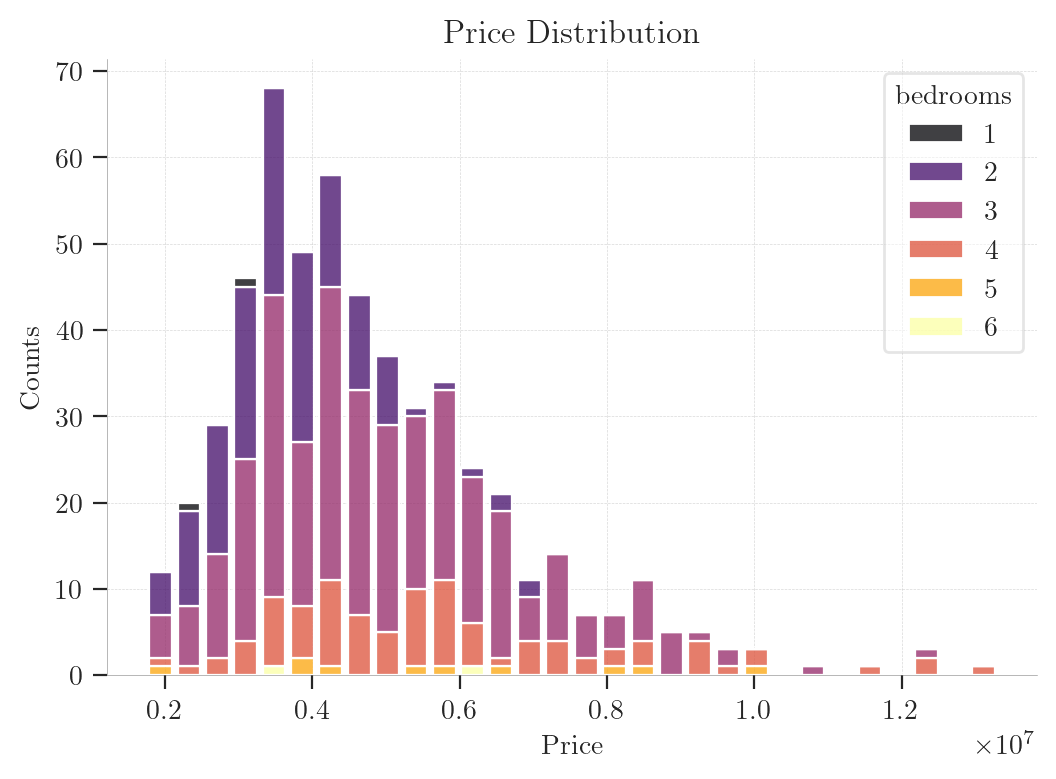

In [8]:
plt.figure(figsize=(6, 4))
sns.histplot(data, x='price', hue='bedrooms', kde=False, bins=30, 
             palette='inferno', multiple='stack', shrink=0.8,
             line_kws={'linewidth': 1, 'ls':'--'})

plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Counts')
plt.show()

In [9]:
data['bedrooms'].value_counts().sort_index()

bedrooms
1      2
2    136
3    300
4     95
5     10
6      2
Name: count, dtype: int64

Since we do not have many data points for 1, 5, and 6 number of bedrooms, we remove them to better train the models.

In [10]:
# Filter out data with bedrooms greater than 4 and less than 2
data = data[(data['bedrooms'] > 1) & (data['bedrooms'] < 5)]

In [11]:
data['bedrooms'].value_counts().sort_index()

bedrooms
2    136
3    300
4     95
Name: count, dtype: int64

### Data manipulation and cleaning

Goals:
- Get the data statistics
- Remove the outliers

I use *Tukey’s Fences* as a method to detect the outliers. This uses the InterQuartile Range (IQR) to define a acceptance region. This is defined as follows:
- Lower Fence = $Q_1 - (1.5 \times \mathrm{IQR})$
- Upper Fence = $Q_3 + (1.5 \times \mathrm{IQR})$

where, 
$\mathrm{IQR} = Q_3 - Q_1$; 

$Q_1$ & $Q_3$ are first and third quartile, respectively.

Therefore, any data point that falls below the Lower Fence or above the Upper Fence is considered an outlier.

In [12]:
# Check for the outliers
data_summary = data.describe().T

# Calculate the IQR
data_summary['IQR'] = data_summary['75%'] - data_summary['25%']

# Calculate the lower and upper bounds
data_summary['lower_bound'] = data_summary['25%'] - 1.5 * data_summary['IQR']
data_summary['upper_bound'] = data_summary['75%'] + 1.5 * data_summary['IQR']

data_summary

,count,mean,std,min,25%,50%,75%,max,IQR,lower_bound,upper_bound
price,531.0,4.754541e+06,1.854889e+06,1750000.0,3430000.0,4340000.0,5740000.0,13300000.0,2310000.0,-35000.0,9205000.0
area,531.0,5.139002e+03,2.123228e+03,1650.0,3600.0,4600.0,6360.0,15600.0,2760.0,-540.0,10500.0
bedrooms,531.0,2.922787e+00,6.556493e-01,2.0,2.0,3.0,3.0,4.0,1.0,0.5,4.5
bathrooms,531.0,1.276836e+00,4.920214e-01,1.0,1.0,1.0,2.0,4.0,1.0,-0.5,3.5
stories,531.0,1.804143e+00,8.748379e-01,1.0,1.0,2.0,2.0,4.0,1.0,-0.5,3.5
parking,531.0,6.986817e-01,8.641596e-01,0.0,0.0,0.0,1.0,3.0,1.0,-1.5,2.5


In [13]:
# Filter out the columns with string elements
cols_without_string_elmts = data.select_dtypes(include=[np.number]).columns
filtered_data = data[cols_without_string_elmts]

# Identify outliers in the data
outliers = (filtered_data < data_summary['lower_bound']) | (filtered_data > data_summary['upper_bound'])

In [14]:
print(f"Number of rows without removing outliers: {data.shape[0]}")
print(f"Number of outliers: {outliers.sum().sum()}")

# Remove the outliers' rows
data = data[outliers.any(axis=1) != True]

print(f"Number of rows after removing outliers: {data.shape[0]}")

Number of rows without removing outliers: 531
Number of outliers: 79
Number of rows after removing outliers: 461


**Note**: If you want to see how these outliers affect the accuracy of the model, skip the above two cells and run the code. You will notice a good difference.

### Data Preprocessing

Goals:
- Encode the categorical variables
- Create new and relevant features for better model training

In [15]:
# Encode the categorical columns using LabelEncoder
le = preprocessing.LabelEncoder()

for column in data.select_dtypes(include=['object']).columns:
    data[column] = le.fit_transform(data[column])

In [16]:
data.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
15,9100000,6000,4,1,2,1,0,1,0,0,2,0,1
16,9100000,6600,4,2,2,1,1,1,0,1,1,1,2
18,8890000,4600,3,2,2,1,1,0,0,1,2,0,0
19,8855000,6420,3,2,2,1,0,0,0,1,1,1,1
20,8750000,4320,3,1,2,1,0,1,1,0,2,0,1


**Comments**:
- Note how the categorical values got converted into numerical values. These are now easy to deal with.


##### Feature Engineering

In [17]:
data['area_per_bedroom'] = data['area'] / data['bedrooms']
data['area_per_bathroom'] = data['area'] / data['bathrooms']
data['area_per_story'] = data['area'] / data['stories']
data['price_per_sqft'] = data['price'] / data['area']

In [18]:
# Perform the log transformation
data['log_price'] = np.log10(data['price'])

**Comments**:
- The new features puts things in context for the model, and also these are something that actually matters while deciding the price for a house.
- We also perform log-transformation so as to restrict the range of the prices.

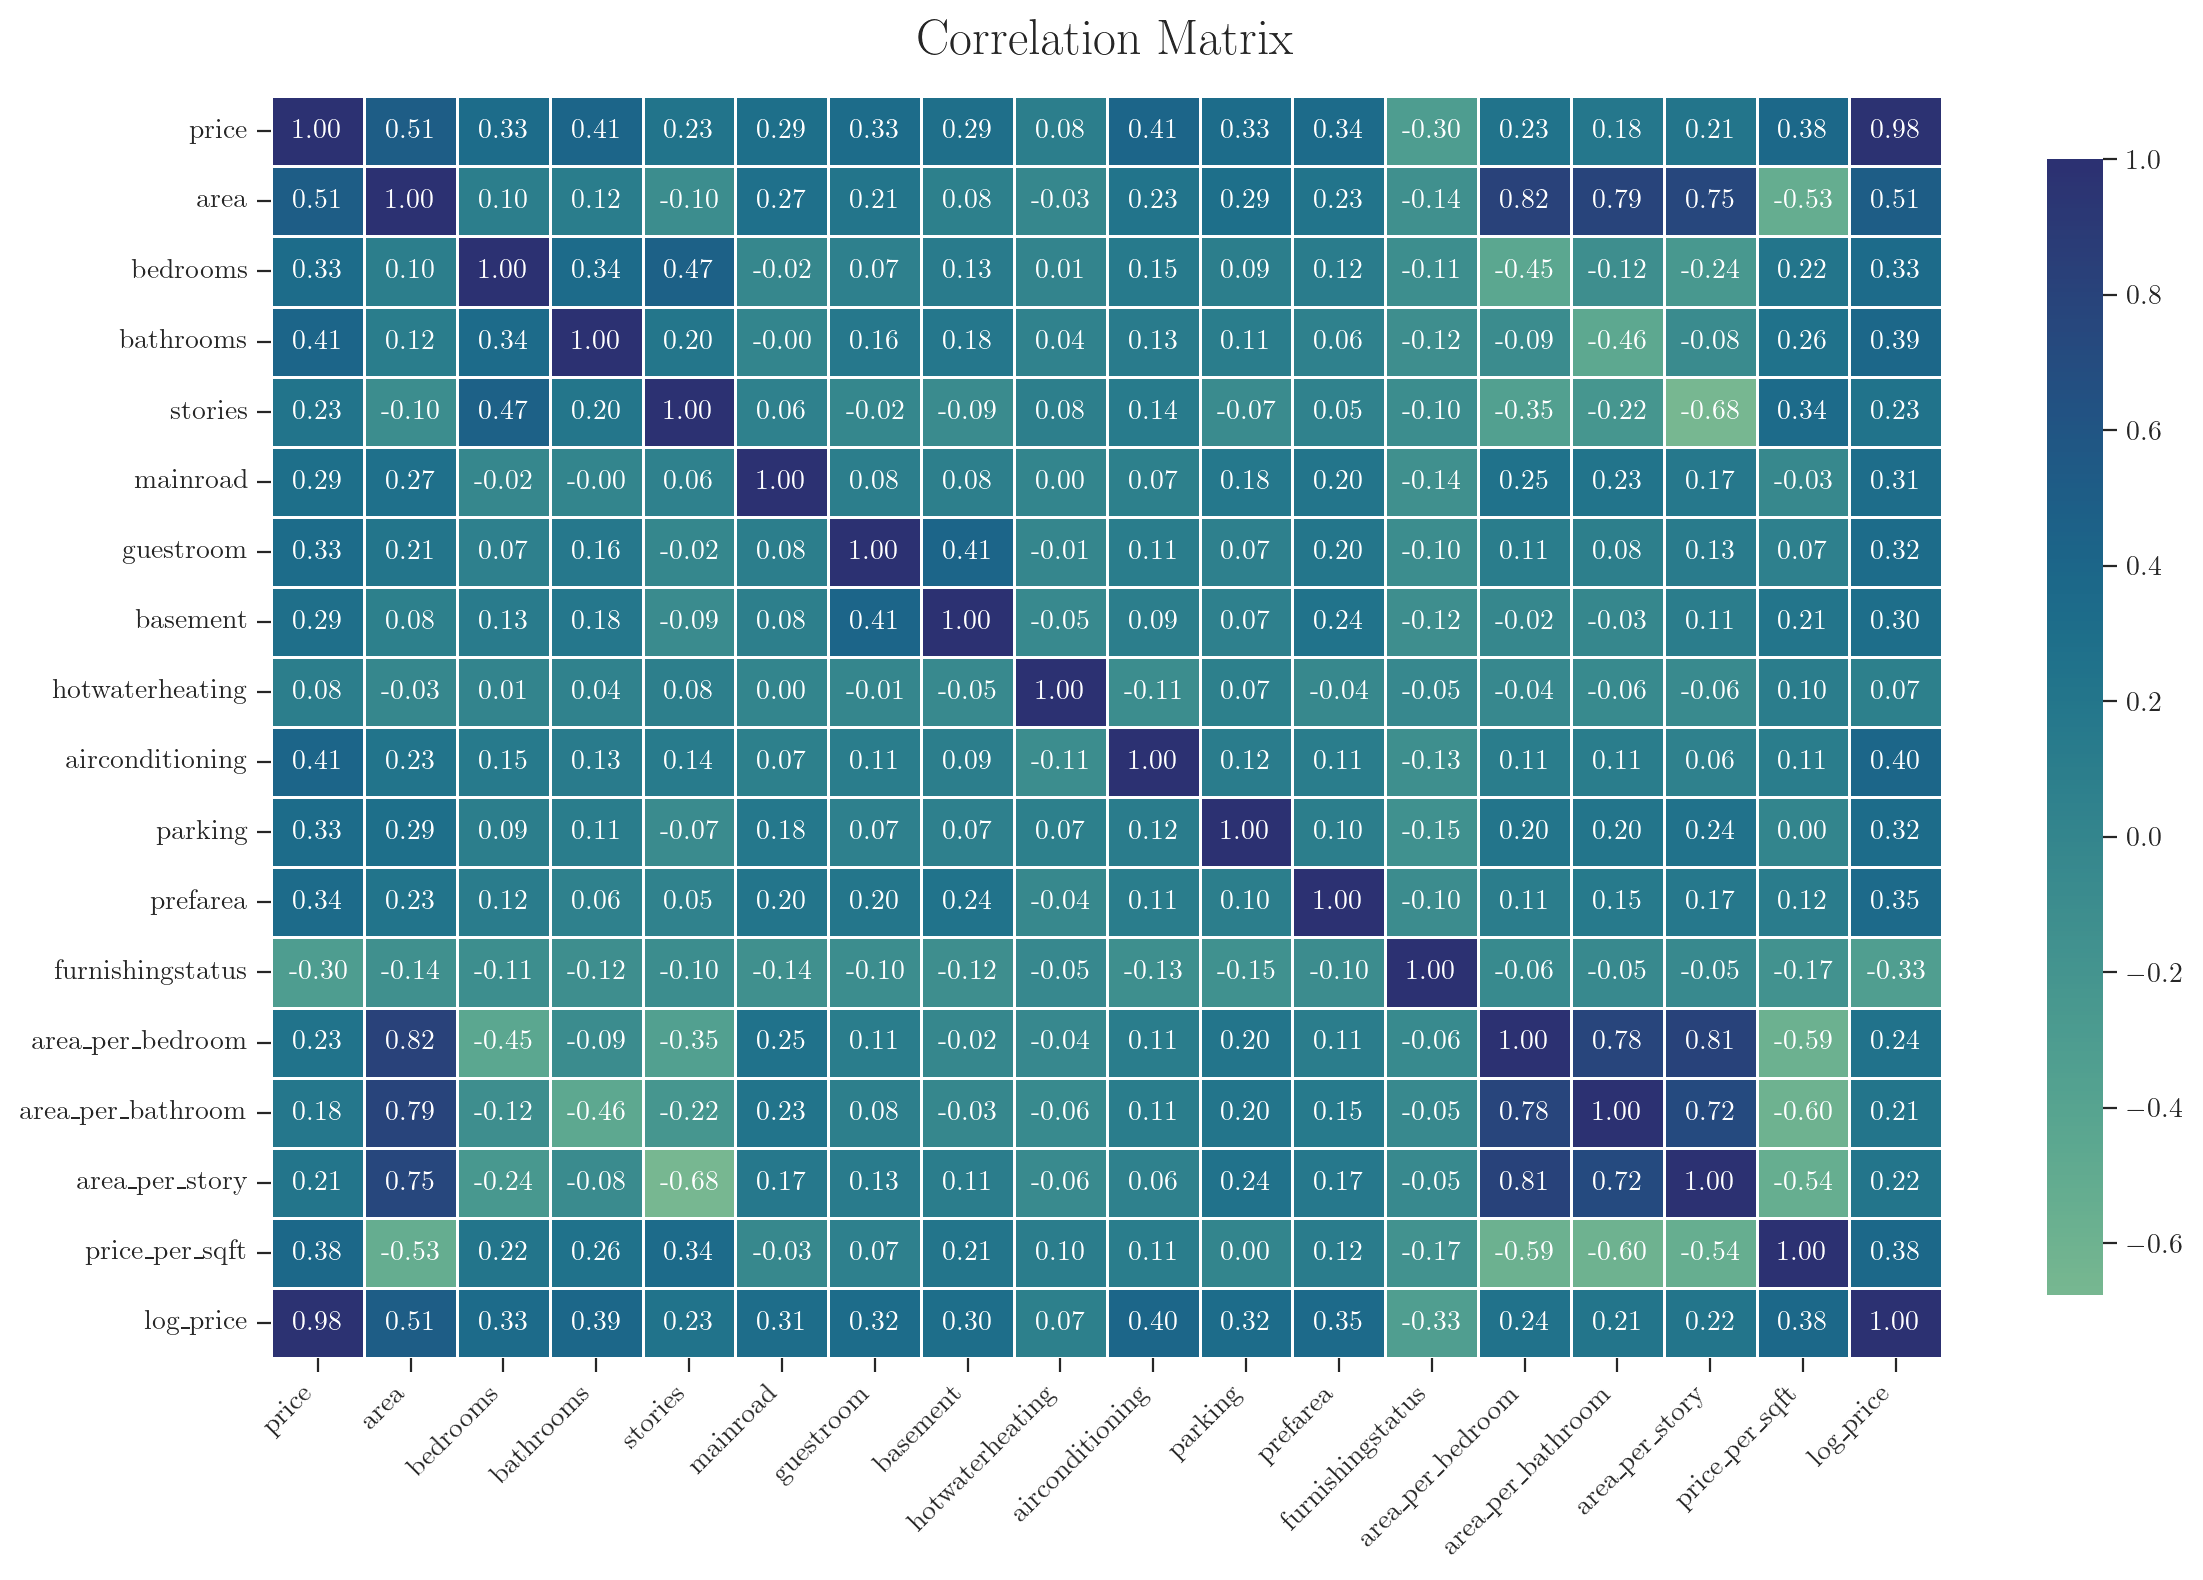

In [19]:
# Check for the correlation between the features
corr_matrix = data.corr()

plt.figure(figsize=(12, 8))

# Create the heatmap
sns.heatmap(
    corr_matrix,
    annot=True,                   # Show correlation coefficients
    fmt=".2f",                    # Format for annotation
    cmap="crest",                 # Color map
    center=0,                     # Center the color map
    linewidths=.5,                # Add lines between cells
    linecolor='white',            # Color of the lines
    cbar_kws={"shrink": 0.9},     # Adjust color bar size
)

# Improve the layout and add titles
plt.title('Correlation Matrix', fontsize=18, pad=15)
plt.xticks(rotation=45, ha='right', fontsize=10)     # Rotate x labels for better readability
plt.yticks(rotation=0, fontsize=10)                  # Adjust y labels


# Show the plot
plt.tight_layout()
plt.show()

In [20]:
data.columns

Index(['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'furnishingstatus', 'area_per_bedroom',
       'area_per_bathroom', 'area_per_story', 'price_per_sqft', 'log_price'],
      dtype='object')

### Split Test and Training set

Goals:
- Split the data into Training (75%) and Test (25%).
- Normalize the values using the z-scores[^1] of respective columns.

[^1]: Z-scores are defined as: $\frac{X - \mu}{\sigma}$, where $X$ is a random variable, $\mu$ & $\sigma$ are the mean and standard deviation of the data

In [21]:
# Split the data into X and y
X = data[['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'furnishingstatus', 'area_per_bedroom',
       'area_per_bathroom', 'area_per_story', 'price_per_sqft']]

Y = data['log_price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

In [22]:
# Standardize the data (using the z-scores)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Train a model using different algorithms

#### 1. Linear Regression

In [23]:
# Using the Linear Regression model
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

# Predict the values
y_pred_lr = model_lr.predict(X_test)

# Calculate model evaluation metrics
mse_lr = metrics.mean_absolute_percentage_error(y_test, y_pred_lr)
r2_lr = metrics.r2_score(y_test, y_pred_lr)

print(f"Mean Absolute Error: {mse_lr:.5f}")
print(f"R2 score: {r2_lr:.5f}")


Mean Absolute Error: 0.01110
R2 score: 0.65473


#### 2. Decision Tree Regressor

In [24]:
model_dtr = DecisionTreeRegressor(max_depth=8)
model_dtr.fit(X_train, y_train)

# Predict the values
y_pred_dtr = model_dtr.predict(X_test)

# Calculate model evaluation metrics
mse_dtr = metrics.mean_absolute_percentage_error(y_test, y_pred_dtr)
r2_dtr = metrics.r2_score(y_test, y_pred_dtr)
print(f'Mean Absolute Error: {mse_dtr:.5f}')
print(f"R2 score: {r2_dtr:.5f}")

Mean Absolute Error: 0.01113
R2 score: 0.52848


#### 3. Random Forest Regressor

In [25]:
model_rfr = ensemble.RandomForestRegressor(n_estimators=40, max_depth=25)
model_rfr.fit(X_train, y_train)

# Predict the values
y_pred_rfr = model_rfr.predict(X_test)

# Calculate model evaluation metrics
mse_rfr = metrics.mean_absolute_percentage_error(y_test, y_pred_rfr)
r2_rfr = metrics.r2_score(y_test, y_pred_rfr)
print(f'Mean Absolute Error: {mse_rfr:.5f}')
print(f"R2 score: {r2_rfr:.5f}")

Mean Absolute Error: 0.00854
R2 score: 0.71949


##### Visualizing the Model performance

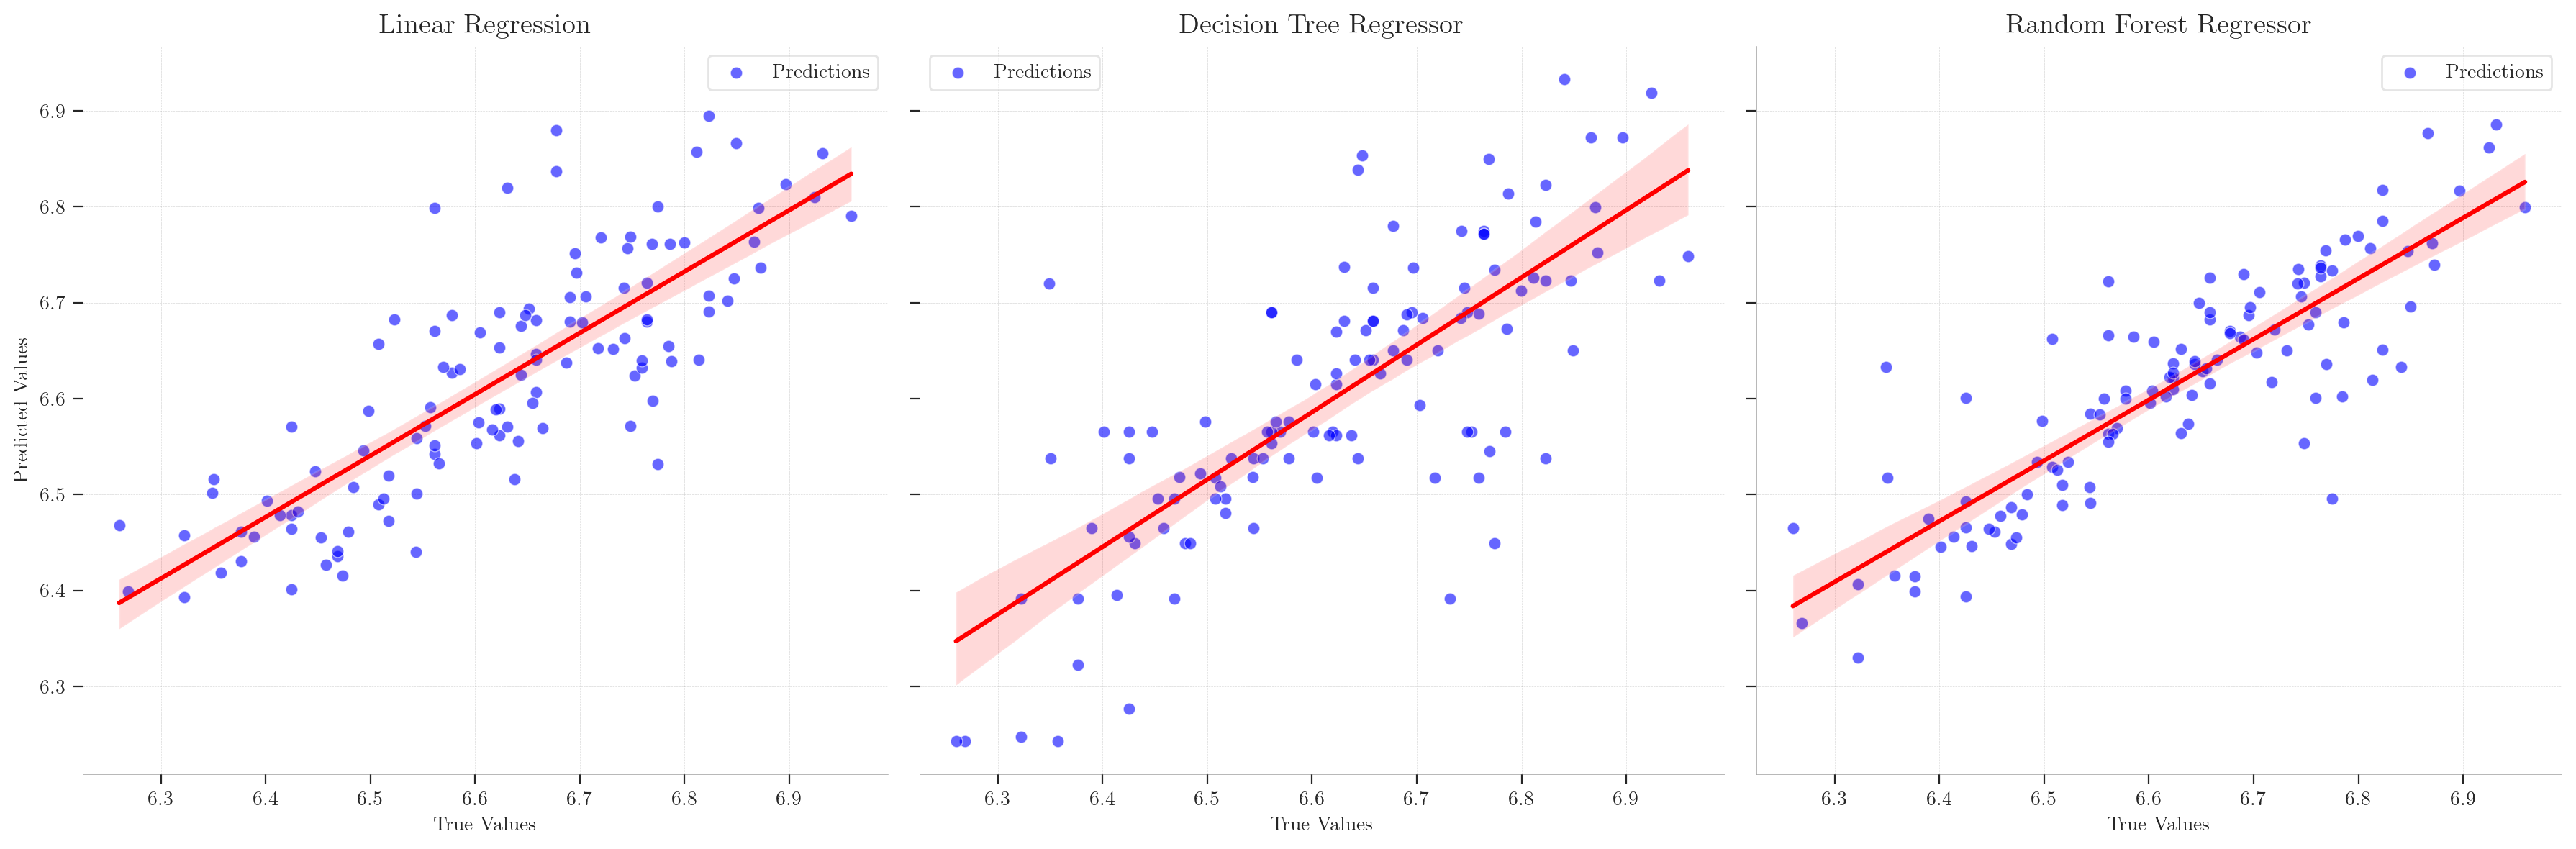

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True, dpi=200)

# List of models and predictions for easier plotting
models = ['Linear Regression', 'Decision Tree Regressor', 'Random Forest Regressor']
predictions = [y_pred_lr, y_pred_dtr, y_pred_rfr]

# Plot each model's predictions
for i, ax in enumerate(axes):
    # Scatter plot of true vs predicted values
    sns.scatterplot(x=y_test, y=predictions[i], ax=ax, alpha=0.6, color="blue", label="Predictions")
    
    # Plot the linear fit line
    sns.regplot(x=y_test, y=predictions[i], ax=ax, scatter=False, color="red", line_kws={"label": "Linear Fit"})
    
    # Set titles and labels
    ax.set_title(models[i], fontsize=14)
    ax.set_xlabel("True Values")
    ax.set_ylabel("Predicted Values")
    
plt.tight_layout()
plt.show()

##### Visualizing the feature importances for different models

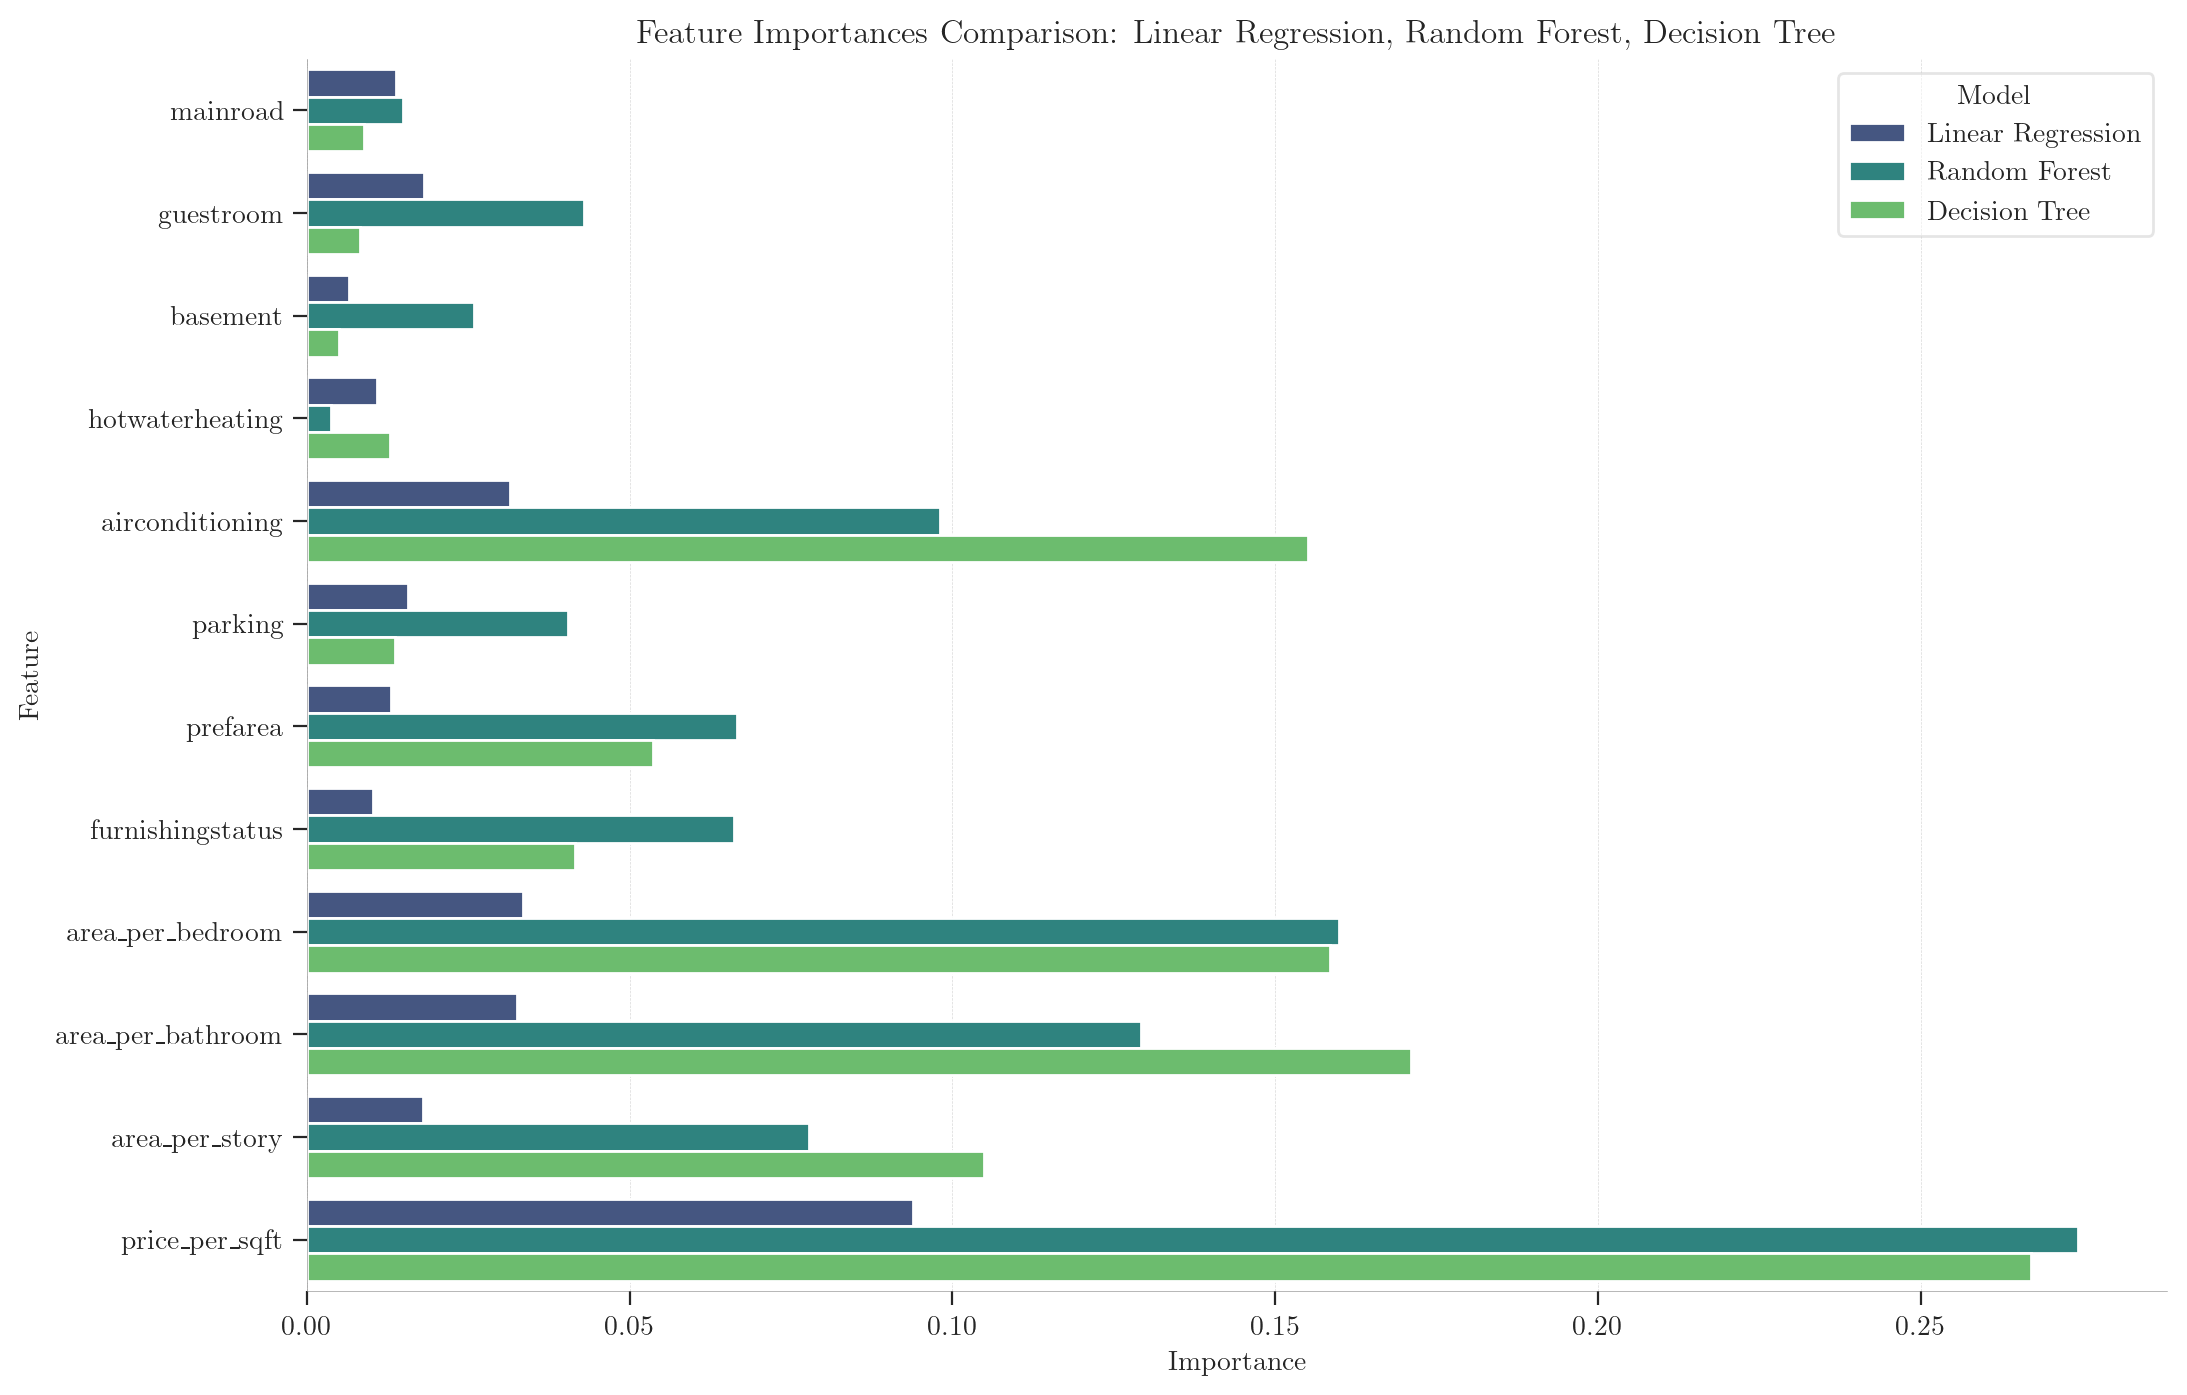

In [27]:
feature_names = X.columns if hasattr(X, "columns") else [f"Feature {i}" for i in range(X.shape[1])]

# Extract feature importances from both models
rf_importances = model_rfr.feature_importances_
dt_importances = model_dtr.feature_importances_

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Linear Regression": np.abs(model_lr.coef_),
    "Random Forest": rf_importances,
    "Decision Tree": dt_importances
})

# Melt the DataFrame for easier plotting with seaborn
importance_melted = importance_df.melt(id_vars="Feature", var_name="Model", value_name="Importance")

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(data=importance_melted, x="Importance", y="Feature", hue="Model", palette="viridis")
plt.title("Feature Importances Comparison: Linear Regression, Random Forest, Decision Tree")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.legend(title="Model")
plt.show()

In [28]:
len(importance_df['Linear Regression'])

12

Conclusions:
- Overall, *price_per_sqft* has the highest one-to-one relation with the price of house, followed by *area_per_bathroom* and *air conditioning*.

#### How the model accuracy varies with hyperparameters?

Goals:
- To see how *Decision Tree Regressor* and *Random Forest Regressor* changes its accuracy with changes in max depth. 

Additional information:
 - Depth is essentially the number of levels in a tree, starting from the root node and extending down to the deepest leaf node. Here’s how max_depth impacts each model:
	
	•	A larger *max_depth* allows the tree to grow deeper, creating more nodes and potentially capturing more intricate patterns in the data.

	•	If *max_depth* is too large, the tree can become too complex, which often leads to overfitting. Overfitting occurs when the model captures noise in the training data, which harms its performance on unseen data.
	
	•	If *max_depth* is too small, the tree may be too simple, leading to underfitting, where the model does not capture enough information from the data.

In [29]:
def dtr(X_train, y_train, X_test, y_test, max_depth):
    model = tree.DecisionTreeRegressor(max_depth=max_depth)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = metrics.mean_absolute_percentage_error(y_test, y_pred)
    r2 = metrics.r2_score(y_test, y_pred)
    return mse, r2

def rfr(X_train, y_train, X_test, y_test, n_estimators, max_depth):
    model = ensemble.RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = metrics.mean_absolute_percentage_error(y_test, y_pred)
    r2 = metrics.r2_score(y_test, y_pred)
    return mse, r2

In [30]:
max_depths = np.arange(1, 100, 3) # Create a range of max_depth values

dtr_mse = [dtr(X_train, y_train, X_test, y_test, max_depth)[0] for max_depth in max_depths]
dtr_r2 = [dtr(X_train, y_train, X_test, y_test, max_depth)[1] for max_depth in max_depths]

rfr_mse = [rfr(X_train, y_train, X_test, y_test, 10, max_depth)[0] for max_depth in max_depths]
rfr_r2 = [rfr(X_train, y_train, X_test, y_test, 10, max_depth)[1] for max_depth in max_depths]

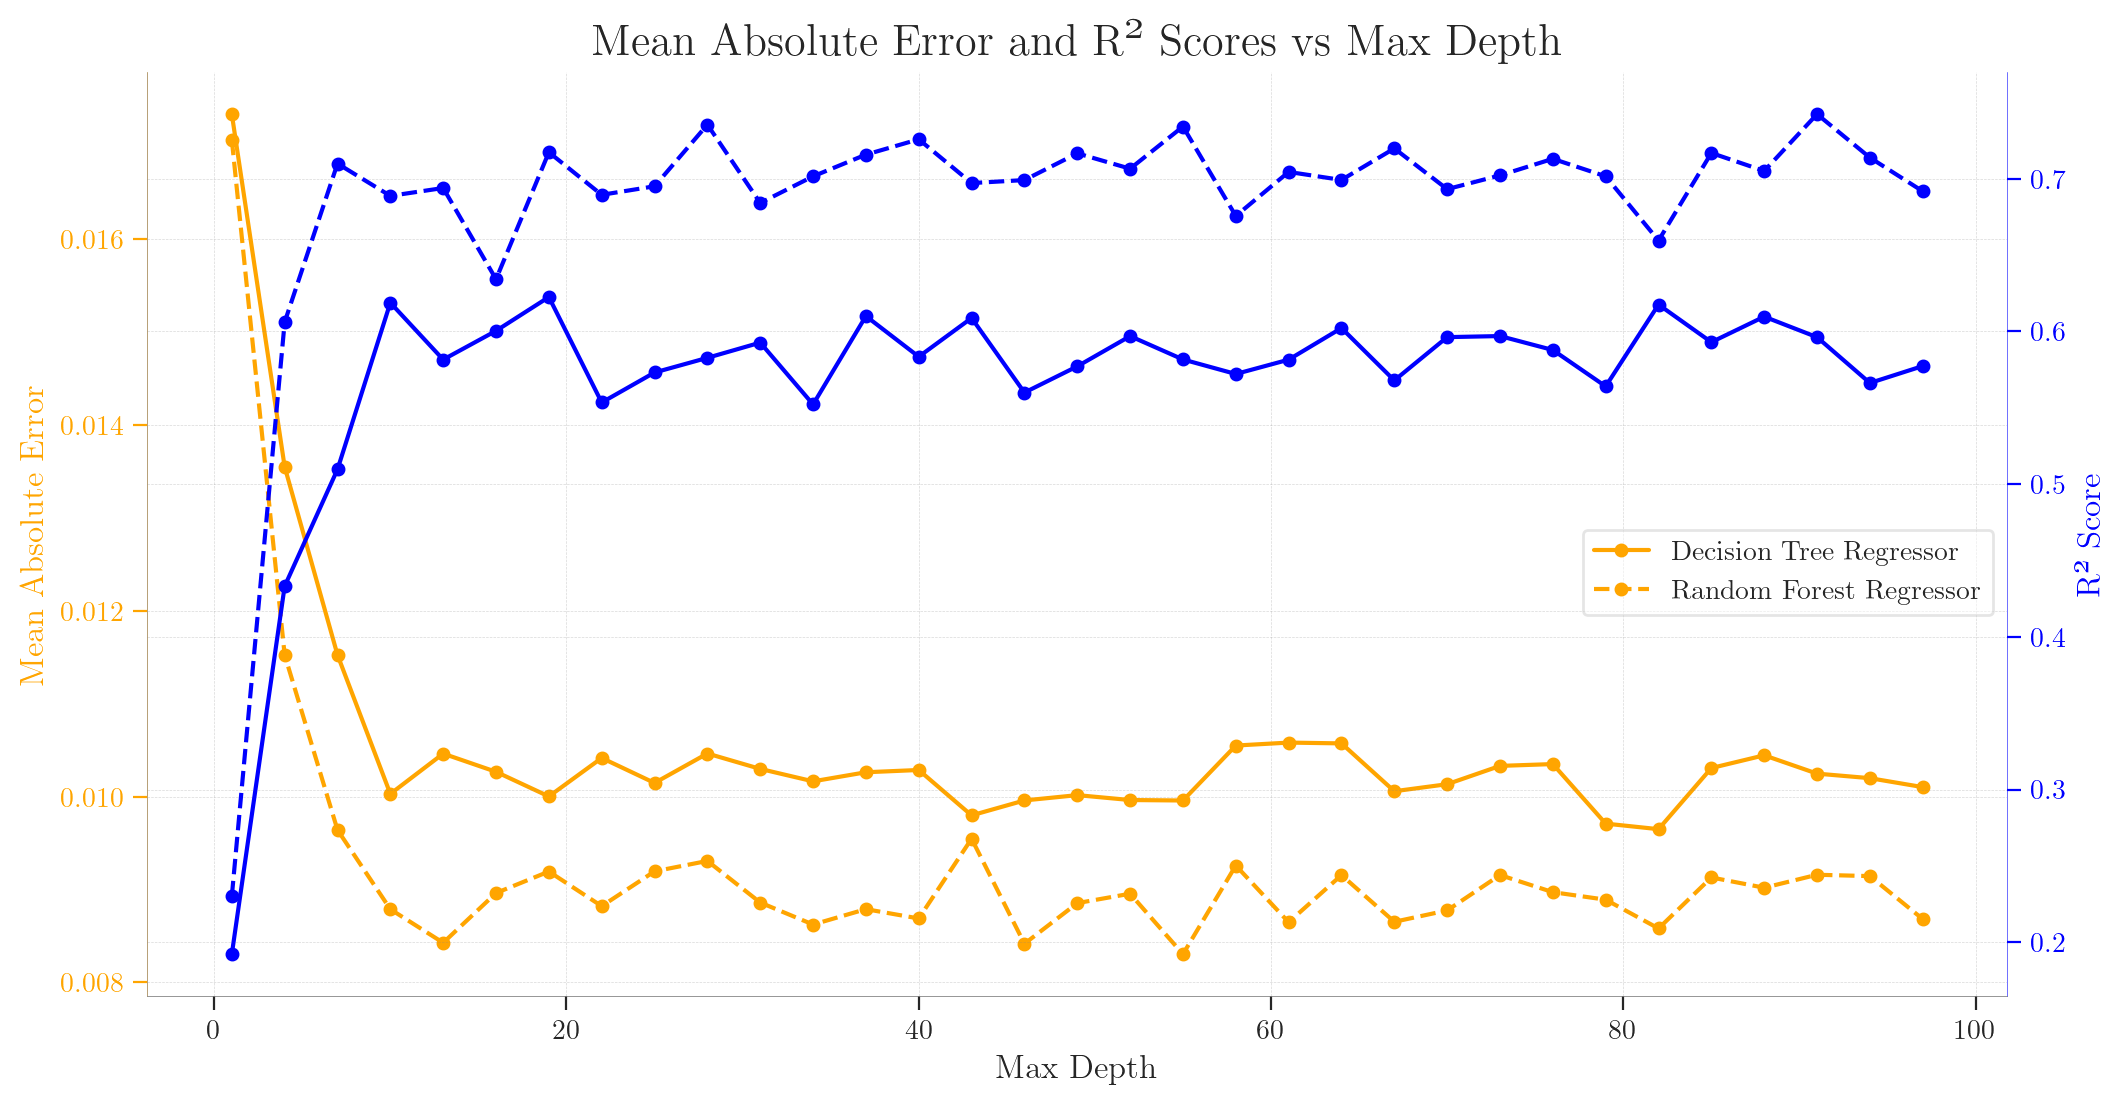

In [31]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the MSE on the left y-axis
ax1.plot(max_depths, dtr_mse, label='Decision Tree Regressor', marker='o', color='orange', ls='-', ms=4)
ax1.plot(max_depths, rfr_mse, label='Random Forest Regressor', marker='o', color='orange', ls='--', ms=4)
ax1.set_xlabel('Max Depth', fontsize=12)
ax1.set_ylabel('Mean Absolute Error', fontsize=12)
ax1.set_title('Mean Absolute Error and R² Scores vs Max Depth', fontsize=16)
ax1.legend(loc='upper left')

# Create a second y-axis for R2 scores
ax2 = ax1.twinx()
ax2.plot(max_depths, dtr_r2, marker='o', color='blue', ls='-', ms=4)
ax2.plot(max_depths, rfr_r2, marker='o', color='blue', ls='--', ms=4)
ax2.set_ylabel('R² Score', fontsize=12)

ax1.legend(loc='upper right', bbox_to_anchor=(1, 0.52))

ax2.spines['right'].set_visible(True)
ax2.spines['right'].set_color('blue')
ax2.yaxis.label.set_color('blue')
ax2.tick_params(axis='y', colors='blue')

ax1.spines['left'].set_color('orange')
ax1.yaxis.label.set_color('orange')
ax1.yaxis.label.set_alpha(1)
ax1.tick_params(axis='y', colors='orange')
plt.show()

___ 
<p style="text-align:center;">END OF THE NOTEBOOK </p>

___
